In [1]:
from Bio.SeqIO.FastaIO import SimpleFastaParser
import numpy as np
import os, sys
import pandas as pd
import pybedtools as pb
import matplotlib.pyplot as plt
import seaborn as sns

LOCAL = True
if LOCAL is True:
    sys.path.append("/Users/sarahfong/tools/py_")
    PATH = "/Users/sarahfong/Desktop/local_data/Biomarin_Jun_2023/"
    MPRA = os.path.join(PATH, "delta_rank.csv")
    #MPRA= os.path.join(PATH, "deltaMPRA.gaba.minus.glut.tsv")
    FASTA = os.path.join(PATH, "library_2", "Design", "biomarin-lib2-hg38-final.fasta")
    META_DATA= os.path.join(PATH, "lib2.meta_data.tsv")
    TILE_BED = os.path.join(PATH, "lib2.processed.bed")
    ENH_BED = os.path.join(PATH,'lib2.processed.merged.bed')
    GREAT_GENE_TSV = os.path.join(PATH, "GREAT", f"region2gene_lib2hg38.tsv")
    DELTA_ACTIVITY= os.path.join(PATH, "deltaMPRA.gaba.minus.glut.tsv")
    DELTA_ACTIVITY_Z= os.path.join(PATH, "deltaMPRA.gaba.minus.glut.zscore.tsv")
    SIG_ACTIVITY_Z= os.path.join(PATH, "WilcoxonSig.gaba.glut.zscore.tsv")
                         
import config_readwrite as crw
import plot_params as pp
pp.fonts()

('sans-serif', 'Arial', 18)

In [2]:
meta = pd.read_csv(META_DATA, sep='\t')
merge = pd.read_csv(ENH_BED, sep='\t')
delta = pd.read_csv(DELTA_ACTIVITY, sep='\t')

merge.head()

,#chr,start.tile,end.tile,coor,#chr.enh,start.enh,end.enh,enh.id,enh.name,tile.order
0,Background seq2 chr1,244100624,244100893,Background seq2 chr1:244100624-244100893:+|Pos...,Background seq2 chr1,244100624,244100893,Background seq2 chr1:244100624-244100893,enh.0,0
1,Background seq2 chr1,244100624,244100893,Background seq2 chr1:244100624-244100893:+|Pos...,Background seq2 chr1,244100624,244100893,Background seq2 chr1:244100624-244100893,enh.0,1
2,Background seq2 chr1,244100624,244100893,Background seq2 chr1:244100624-244100893:+|Pos...,Background seq2 chr1,244100624,244100893,Background seq2 chr1:244100624-244100893,enh.0,2
3,Background seq2 chr1,244100624,244100893,Background seq2 chr1:244100624-244100893:+|Pos...,Background seq2 chr1,244100624,244100893,Background seq2 chr1:244100624-244100893,enh.0,3
4,Background seq2 chr1,244100624,244100893,Background seq2 chr1:244100624-244100893:+|Pos...,Background seq2 chr1,244100624,244100893,Background seq2 chr1:244100624-244100893,enh.0,4


In [3]:
len(set(merge["enh.id"]))

1827

# load MPRA data

In [4]:
mpra = pd.read_csv(MPRA)
#mpra = mpra.rename(columns ={"delta.gaba-glut":"delta"})
print(mpra.shape)
mpra.head()

(35371, 5)


,name,gaba_log2_mean,glut_log2_mean,delta,delta_rank
0,chr1:10339772-10340042,-1.602773,0.466691,-2.069465,1.0
1,chr6:154127563-154127833,-0.460660,1.393760,-1.854420,2.0
2,chr4:93216597-93216867,-1.373226,0.426283,-1.799509,3.0
3,chr9:127735295-127735565,-0.784093,1.010851,-1.794944,4.0
4,chr1:31376876-31377146,-0.500106,1.291683,-1.791789,5.0


[Text(0.5, 1.0, 'delta MPRA'),
 Text(0.5, 0, 'delta\nmean log2(gaba) - mean log2(glut)')]

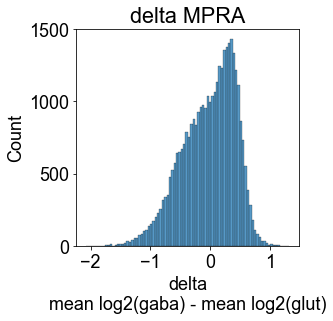

In [5]:
fig, ax = plt.subplots(figsize=(4,4))
sns.histplot(mpra["delta"])
ax.set(title="delta MPRA",
      xlabel="delta\nmean log2(gaba) - mean log2(glut)")

In [6]:
mpra["delta"].describe()

count    35371.000000
mean        -0.023292
std          0.442305
min         -2.069465
25%         -0.325397
50%          0.043795
75%          0.324542
max          1.319865
Name: delta, dtype: float64

# evaluate GREAT

In [7]:
# get nearby coordinates using GREAT nearest 2 gene function

## load great annotations

In [8]:
GREAT_GENE = os.path.join(os.path.split(MPRA)[0], "GREAT", f"region2gene_lib2hg38.txt")

locus_dict = {}
with open(GREAT_GENE, "r") as reader:
    for line in reader:
        if "#" not in line and line !="\n":
            
            locus, genes = line.strip("\n").split("\t")  # split on tab to get gene name

            info = [locus]
            
            for n, i in enumerate(genes.split(",")):
                if i != "NONE":
                    gene, dist = i.strip(" ").split(" ")
                    dist = dist.strip("()")
                else:
                    gene, dist = "na", "na"
                
                locus_dict[f'{locus}-{n}'] = [locus, gene, dist]


vstack = np.vstack(locus_dict.values())

great = pd.DataFrame(vstack)
great.columns = ["coor", "gene", 'dist']
great = great.loc[great.dist!="na"]  # remove any elements w/ no genes
great.head()

/Users/sarahfong/miniconda3/envs/base_venv/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


,coor,gene,dist
0,chr1:101316025-101316295,S1PR1,+79272
1,chr1:101316025-101316295,OLFM3,+530813
2,chr1:101316045-101316315,S1PR1,+79292
3,chr1:101316045-101316315,OLFM3,+530793
4,chr1:101316065-101316335,S1PR1,+79312


# add GREAT annotations to fasta meta data

In [9]:
enh = pd.merge(great, meta)

# rename columns for merging with MPRA data
enh = enh.rename(columns ={"start":"start.tile",
                           "end":"end.tile"})

enh.head()

,coor,gene,dist,name,sequence,bkgd,h,ctrl,cl,top_bottom,strand,#chr,start.tile,end.tile
0,chr1:101316025-101316295,S1PR1,+79272,chr1:101316025-101316295,AGGACCGGATCAACTAGAGTCACCCCTGCTGTTCCCCGTAGGATGA...,False,NaN,NaN,NaN,NaN,+,chr1,101316025.0,101316295
1,chr1:101316025-101316295,OLFM3,+530813,chr1:101316025-101316295,AGGACCGGATCAACTAGAGTCACCCCTGCTGTTCCCCGTAGGATGA...,False,NaN,NaN,NaN,NaN,+,chr1,101316025.0,101316295
2,chr1:101316045-101316315,S1PR1,+79292,chr1:101316045-101316315,AGGACCGGATCAACTCCGTAGGATGACGCTGGTGTAAAAAGGTTAC...,False,NaN,NaN,NaN,NaN,+,chr1,101316045.0,101316315
3,chr1:101316045-101316315,OLFM3,+530793,chr1:101316045-101316315,AGGACCGGATCAACTCCGTAGGATGACGCTGGTGTAAAAAGGTTAC...,False,NaN,NaN,NaN,NaN,+,chr1,101316045.0,101316315
4,chr1:101316065-101316335,S1PR1,+79312,chr1:101316065-101316335,AGGACCGGATCAACTAAAAAGGTTACCGTTGCTTCAGTGGCCCTTG...,False,NaN,NaN,NaN,NaN,+,chr1,101316065.0,101316335


# add MPRA

In [10]:
enh = pd.merge(enh, mpra).drop_duplicates()

mpra.head()

,name,gaba_log2_mean,glut_log2_mean,delta,delta_rank
0,chr1:10339772-10340042,-1.602773,0.466691,-2.069465,1.0
1,chr6:154127563-154127833,-0.460660,1.393760,-1.854420,2.0
2,chr4:93216597-93216867,-1.373226,0.426283,-1.799509,3.0
3,chr9:127735295-127735565,-0.784093,1.010851,-1.794944,4.0
4,chr1:31376876-31377146,-0.500106,1.291683,-1.791789,5.0


In [11]:
enh = pd.merge(enh, delta).drop_duplicates()

# merge enhancer info w/ MPRA info

In [12]:
# add enhancer coordinate information
enh[["start.tile", "end.tile"]] = enh[["start.tile", "end.tile"]].astype(int)

enh = pd.merge(enh, merge,
               left_on=["#chr", "start.tile", "end.tile", "coor"],
               right_on=["#chr", "start.tile", "end.tile", "coor"])
enh = enh.sort_values(by=["#chr", "start.tile", "end.tile"])

enh.head()

,coor,gene,dist,name,sequence,bkgd,h,ctrl,cl,top_bottom,...,celltype_dif,gaba,glut,delta.gaba-glut,#chr.enh,start.enh,end.enh,enh.id,enh.name,tile.order
1678,chr1:1692002-1692272,CDK11B,-33125,chr1:1692002-1692272,AGGACCGGATCAACTCTCGTTTGGCCTGAAAATGTGATTTGCAGGC...,False,NaN,NaN,NaN,NaN,...,False,0.525588,0.205703,0.319886,chr1,1692002,1692432,chr1:1692002-1692432,enh.46,0
1679,chr1:1692002-1692272,SLC35E2B,+507,chr1:1692002-1692272,AGGACCGGATCAACTCTCGTTTGGCCTGAAAATGTGATTTGCAGGC...,False,NaN,NaN,NaN,NaN,...,False,0.525588,0.205703,0.319886,chr1,1692002,1692432,chr1:1692002-1692432,enh.46,0
1680,chr1:1692022-1692292,CDK11B,-33145,chr1:1692022-1692292,AGGACCGGATCAACTGATTTGCAGGCTTCCTGAGCAAAGTAGATTT...,False,NaN,NaN,NaN,NaN,...,False,0.602023,0.072854,0.529169,chr1,1692002,1692432,chr1:1692002-1692432,enh.46,1
1681,chr1:1692022-1692292,SLC35E2B,+487,chr1:1692022-1692292,AGGACCGGATCAACTGATTTGCAGGCTTCCTGAGCAAAGTAGATTT...,False,NaN,NaN,NaN,NaN,...,False,0.602023,0.072854,0.529169,chr1,1692002,1692432,chr1:1692002-1692432,enh.46,1
1682,chr1:1692042-1692312,CDK11B,-33165,chr1:1692042-1692312,AGGACCGGATCAACTAAAGTAGATTTCACTCCATTAAAGAAAAAAA...,False,NaN,NaN,NaN,NaN,...,False,0.532336,0.115079,0.417256,chr1,1692002,1692432,chr1:1692002-1692432,enh.46,2


# add significance data

In [13]:
sig_reps= pd.read_csv(SIG_ACTIVITY_Z, sep='\t')
sig_reps.head()

,name,gaba_1,gaba_2,gaba_3,glut_1,glut_2,glut_3,pval,-log10p
0,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.794103,-2.970164,-2.334829,-1.249982,-1.717908,-2.121743,0.037107,1.430540
1,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.671559,-2.830269,-2.548998,-1.803647,-3.098993,-0.318147,0.361064,0.442415
2,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.273753,-2.155235,-2.255196,-2.009413,-2.922402,-0.596232,0.626615,0.202999
3,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.705924,-2.665966,-2.627832,-0.626111,-2.827502,-1.210420,0.233208,0.632257
4,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.645673,-2.565910,-3.058675,-2.246619,-1.618896,-3.649946,0.719958,0.142693


## example

In [124]:
sig_reps.sample(n=3)

,name,gaba_1,gaba_2,gaba_3,glut_1,glut_2,glut_3,pval,-log10p
8735,chr15:25438053-25438323,-0.062600,-0.232679,-0.323670,-0.464047,-0.251571,-0.395356,0.175227,0.756400
27050,chr5:116953346-116953616,0.917277,0.904258,1.016101,0.978306,0.674565,1.267513,0.888090,0.051543
34948,chrX:73214816-73215086,-0.563214,-0.499954,-0.477129,0.080821,0.184099,0.344194,0.006440,2.191134


In [14]:
enh= pd.merge(enh, sig_reps).drop_duplicates()
enh["sig"] = enh["pval"].apply(lambda x: True if x<0.05 else False)

enh["gaba"] = enh[["gaba_1", "gaba_2", "gaba_3"]].mean(axis=1)

enh["glut"] = enh[["glut_1", "glut_2", "glut_3"]].mean(axis=1)
enh["delta.gaba-glut"] = enh["gaba"]-enh["glut"]
enh.head()

,coor,gene,dist,name,sequence,bkgd,h,ctrl,cl,top_bottom,...,tile.order,gaba_1,gaba_2,gaba_3,glut_1,glut_2,glut_3,pval,-log10p,sig
0,chr1:1692002-1692272,CDK11B,-33125,chr1:1692002-1692272,AGGACCGGATCAACTCTCGTTTGGCCTGAAAATGTGATTTGCAGGC...,False,NaN,NaN,NaN,NaN,...,0,0.685248,0.543905,0.885495,0.440009,0.084332,0.285533,0.038349,1.416245,True
1,chr1:1692002-1692272,SLC35E2B,+507,chr1:1692002-1692272,AGGACCGGATCAACTCTCGTTTGGCCTGAAAATGTGATTTGCAGGC...,False,NaN,NaN,NaN,NaN,...,0,0.685248,0.543905,0.885495,0.440009,0.084332,0.285533,0.038349,1.416245,True
2,chr1:1692022-1692292,CDK11B,-33145,chr1:1692022-1692292,AGGACCGGATCAACTGATTTGCAGGCTTCCTGAGCAAAGTAGATTT...,False,NaN,NaN,NaN,NaN,...,1,0.900345,0.683593,0.863889,0.120514,-0.037276,-0.160445,0.001545,2.811004,True
3,chr1:1692022-1692292,SLC35E2B,+487,chr1:1692022-1692292,AGGACCGGATCAACTGATTTGCAGGCTTCCTGAGCAAAGTAGATTT...,False,NaN,NaN,NaN,NaN,...,1,0.900345,0.683593,0.863889,0.120514,-0.037276,-0.160445,0.001545,2.811004,True
4,chr1:1692042-1692312,CDK11B,-33165,chr1:1692042-1692312,AGGACCGGATCAACTAAAGTAGATTTCACTCCATTAAAGAAAAAAA...,False,NaN,NaN,NaN,NaN,...,2,0.843475,0.629019,0.671565,0.092951,-0.316702,0.428499,0.084744,1.071892,False


## plot deltas

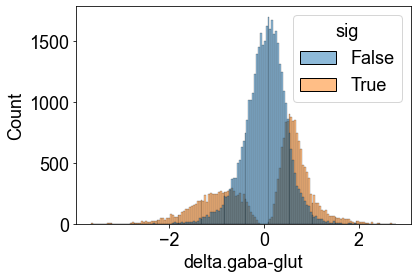

In [15]:
sns.histplot(x="delta.gaba-glut", data=enh, hue="sig")
out = os.path.join(PATH, "enh_maps", "delta.distribution.pdf")
plt.savefig(out, bbox_inches='tight')

## add direction to  delta values

In [87]:
def responseDirection(df):
    col = "direction"
    df[col] = None
    inspection_cols = [col,
                   'delta.gaba-glut',
                   "gaba",
                   "glut",
                   'gaba_1',
                   'gaba_2',
                   'gaba_3',
                   'glut_1',
                   'glut_2',
                   'glut_3']

    df.loc[(df['gaba'] < 0)
            & (df['glut'] < 0)
            & (df["delta.gaba-glut"] < 0),
            col] = "both negative, GABA<GLUT"  # GABA is more silencing than glut

    df.loc[(df['gaba'] < 0)
            & (df['glut'] < 0)
            & (df["delta.gaba-glut"] > 0),
            col] = "both negative, GLUT<GABA"  # GLUT is more silencing than GABA

    df.loc[(df['gaba'] > 0)
            & (df['glut'] > 0)
            & (df["delta.gaba-glut"] < 0),
            col] = "both positive GLUT>GABA"  # GLUT is more active than GABA

    df.loc[(df['gaba'] > 0)
            & (df['glut'] > 0)
            & (df["delta.gaba-glut"] > 0),
            col] = "both positive GABA>GLUT"  # GABA is more active than GLUT

    df.loc[(df['gaba'] <0)
            & (df['glut'] > 0)
            & (df["delta.gaba-glut"] < 0),
            col] = "positive GLUT>negative GABA"  # GLUT is active, GABA is not

    df.loc[(df['gaba'] > 0)
            & (df['glut'] < 0)
            & (df["delta.gaba-glut"] > 0),
            col] = "positive GABA>negative GLUT"  # GABA is active, glut is not. 

    print("unlabeled", df.loc[df[col].isna(), inspection_cols].shape[0])

    return df.drop_duplicates()

In [125]:
# add direction annotations based on sign of mean GABA, GLUT activity value
enh = responseDirection(enh)

unlabeled 0


### inspect each of the delta calls visually. 
- note there is no case where Glut is positive and GABA is negative. 

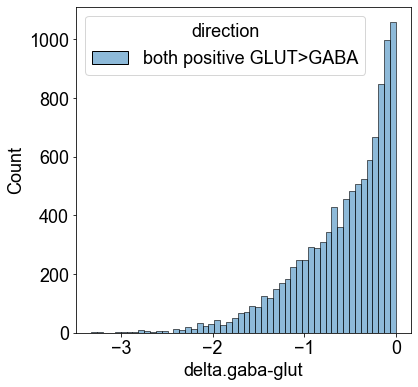

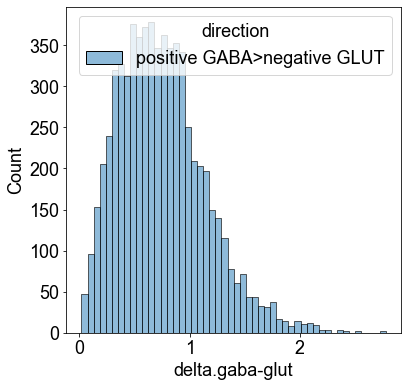

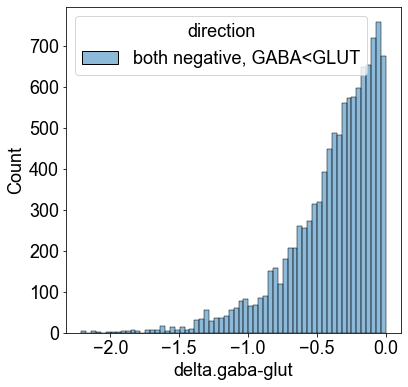

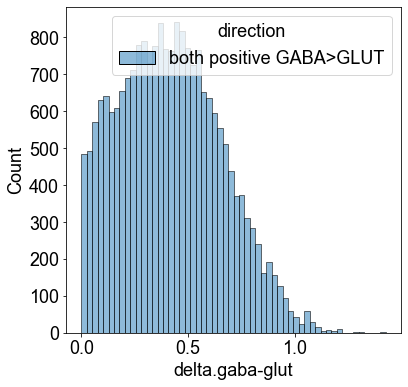

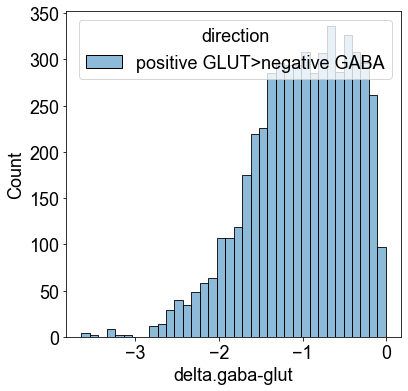

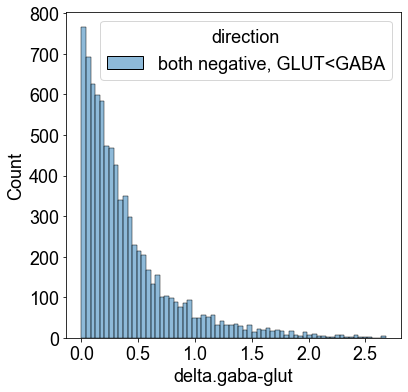

In [48]:
for dir_ in set(enh[col]):
    fig, ax=plt.subplots(figsize=(6,6))
    sns.histplot(x="delta.gaba-glut", data=enh.loc[enh[col]==dir_], hue="direction")
    #plt.legend(bbox_to_anchor=(1,1))
    out = os.path.join(PATH, "enh_maps", "delta.distribution.pdf")
    #plt.savefig(out, bbox_inches='tight')

In [90]:
sns.kdeplot

<function seaborn.distributions.kdeplot(x=None, *, y=None, shade=None, vertical=False, kernel=None, bw=None, gridsize=200, cut=3, clip=None, legend=True, cumulative=False, shade_lowest=None, cbar=False, cbar_ax=None, cbar_kws=None, ax=None, weights=None, hue=None, palette=None, hue_order=None, hue_norm=None, multiple='layer', common_norm=True, common_grid=False, levels=10, thresh=0.05, bw_method='scott', bw_adjust=1, log_scale=None, color=None, fill=None, data=None, data2=None, warn_singular=True, **kwargs)>

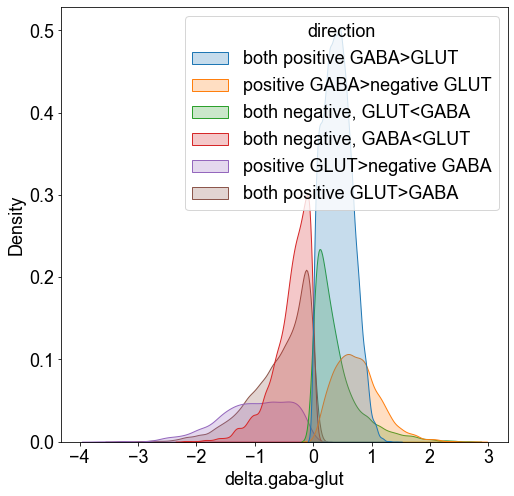

In [92]:
fig, ax=plt.subplots(figsize=(8,8))
sns.kdeplot(x="delta.gaba-glut", data=enh, hue="direction", fill=True)
#ax.legend(bbox_to_anchor=(1,1))
out = os.path.join(PATH, "enh_maps", "delta.distribution.pdf")
#plt.savefig(out, bbox_inches='tight')

## combine significant ttest and celltype_dif (categorical) labels

In [93]:
enh["sig_n_dif"] = enh["sig"].map(str) + "." + enh["celltype_dif"].map(str)

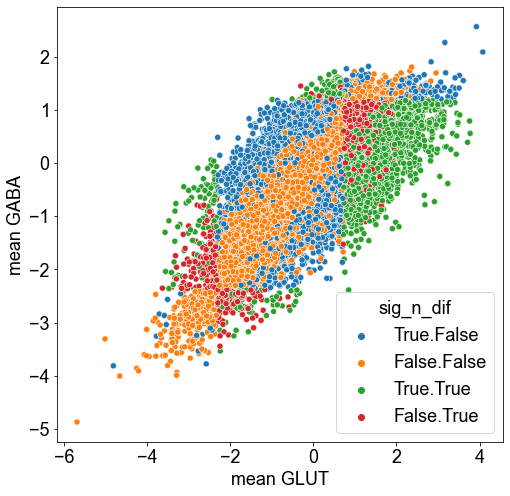

In [129]:
fig, ax= plt.subplots(figsize=(8,8))
sns.scatterplot(y="gaba", x="glut", data=enh, hue="sig_n_dif")
out = os.path.join(PATH, "enh_maps", "cell-type-dif.scatter.pdf")
ax.set(xlabel="mean GLUT", 
      ylabel="mean GABA")
plt.savefig(out, bbox_inches='tight')

In [128]:
out

'/Users/sarahfong/Desktop/local_data/Biomarin_Jun_2023/enh_maps/cell-type-dif.scatter.pdf'

In [58]:
enh[["name", "celltype_dif"]].drop_duplicates().groupby("celltype_dif")['name'].count()

celltype_dif
False    27814
True      6241
Name: name, dtype: int64

In [59]:
def getMinDist(df):
    """return str of gene, min distance tuples to gene TSSs per one enhancer
        note - most enhancers map to two genes, which means two TSSs
    """

    genes = []

    # per gene
    for gene in df["gene"].unique():
        genes.append(gene)

        # get the gene dataframe
        g = df.loc[df["gene"] == gene].copy()

        # if upstream TSS, return min value
        if int(g.dist.min()) > 1:
            genes.append(g.dist.min())

        # elif downstream TSS, return max negative value (min)
        elif int(g.dist.min()) < 1:
            genes.append(g.dist.max())
        elif list(set(g.dist)) == "na":
            print(gene,  "TO REMOVE")
            genes = genes[:-1]  # remove gene from list, no distance

    return "_".join(genes)

In [60]:
def plot_lineplot(test, out, enh_id,  enh_name, gene_name):

    fig, ax = plt.subplots(figsize=(12, 4))

    test["tile.order"] = test["tile.order"].astype(int)
    test = test.sort_values(by="tile.order")

    # lineplots
    sns.pointplot(x="tile.order", y="glut", data=test,
                  color="blue", label="glut", ax=ax)
    sns.pointplot(x="tile.order", y="gaba", data=test,
                  color="orange", label="gaba", ax=ax)
    
    # zero line
    ax.axhline(0, c="grey", ls="--")

    # ax title, labels
    ax.set(title=f"{gene_name}bp to TSS\n{enh_id}",
           # ylabel = "log2(RNA/DNA)",
           ylabel="mean z-score"
           )

    plt.savefig(out, bbox_inches="tight")
    
    plt.show()
    plt.close()

# heatmap

In [61]:
def plot_heatmap(test, out, enh_id, enh_name, gene_name):
    t = test[["gaba", "glut", "enh.id", 'gaba-label',
              'glut-label', "tile.order"]].drop_duplicates().sort_values(by=["tile.order"])

    # columns for heatmap, labeling
    table1_cols = ["gaba", "glut"]
    table2_cols = ['gaba-label', 'glut-label']

    t = t.set_index("tile.order")

    fig, ax = plt.subplots()

    # annotation labels
    t[table2_cols] = t[table2_cols].replace(
        "False", "\n\n")
    t[table2_cols] = t[table2_cols].replace(
        "silencing", "\n\n-")
    t[table2_cols] = t[table2_cols].replace(
        "activating", "\n\n+")

    labels = np.array(t[table2_cols].T)

    sns.heatmap(t[table1_cols].T,
                cmap="bwr", center=0,   #square=True, 
                annot=labels,  fmt="", alpha=0,
                cbar=False,
                # cbar_kws={"shrink": 0.5},
                ax=ax)
    sns.heatmap(t[table1_cols].T,
                cmap="bwr", center=0,
                annot=True,  fmt=".2", #square=True, 
                cbar_kws={'label': 'mean z-score'},
                # cbar_kws={"shrink": 0.5},
                ax=ax)
    ax.set(title=f"{gene_name} bp to TSS\n{enh_name}, {enh_id}")

    plt.savefig(out, bbox_inches="tight")
    plt.show()
    plt.close()

In [62]:
def getEnhid(tile_coor, df):
    """return enhancer coordinate for tile_id"""
    enh = set(df.loc[df["coor"] == tile_coor, 'enh.id'])
    
    if len(enh)>1:
        print("more than one enh_id", enh)
    
    # return the first (and hopefully only) enh
    return list(enh)[0]

    

In [63]:
def plotTile(tile_coor, df):

    # get enh_id for tile coordinate
    enh_id = getEnhid(tile_coor, df)
    t = df.loc[df["enh.id"] == enh_id].drop_duplicates().copy()
    # stratify by gene name, as one enhancer may be near two different genes

    enh_name = list(set(t["enh.name"]))[0]
    gene = getMinDist(t)

    out_line = os.path.join(PATH, "enh_maps", f"{gene}.{enh_name}.line.pdf")

    # plot line
    plot_lineplot(t, out_line, enh_id,  enh_name, gene)

    # plot heat
    out_heat = os.path.join(PATH, "enh_maps",  f"{gene}.{enh_name}.heatmap.pdf")
    plot_heatmap(t, out_heat, enh_id, enh_name, gene)

    return t

# nominate candidates

## bootstrap delta activity score to - Select for largest effect size differences. 

In [64]:
bs =1000
bs_results975, bs_results025 = [], []
for i in np.arange(bs):
    bsdf = enh[["coor", "gaba", "glut", "delta.gaba-glut"]].drop_duplicates().copy()
    sample = bsdf["delta.gaba-glut"].sample(n=bsdf.shape[0], replace=True)
   
    # bootstrap 95% confidence intervals 
    bs_results975.append(sample.quantile(0.975))
    bs_results025.append(sample.quantile(0.025))

## keep only delta values more extreme than bootstrapped delta distribution

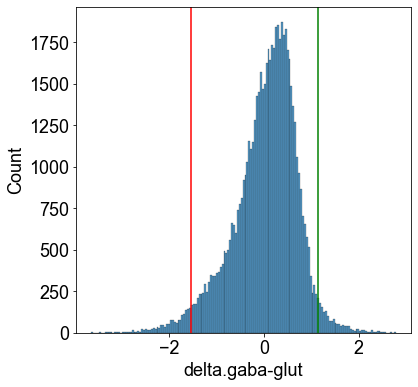

In [154]:
fig, ax=plt.subplots(figsize=(6,6))
sns.histplot(enh["delta.gaba-glut"], label=f"full")
ax.axvline(np.median(bs_results975), label=f"97.5%, median bs delta", color="green")
ax.axvline(np.median(bs_results025), label=f"2.5%, median bs delta", color="red")
ax.legend().remove()
ax.set(xlabel="delta.gaba-glut")
out = os.path.join(PATH, "bs-deltas.pdf")
plt.savefig(out, bbox_inches='tight')

In [120]:
cols = ["coor", "gene", "dist", "name", "gaba", "glut",
        "gaba-label", "glut-label",
        'delta.gaba-glut', "enh.name", "enh.id", 'tile.order', "sig", "direction"]
test = enh[cols].drop_duplicates().copy()

test["delta.gaba-glut"] = test['gaba']-test['glut']
top = test.loc[test["delta.gaba-glut"].map(float)
               > np.max(bs_results975), "coor"]

bottom = test.loc[test["delta.gaba-glut"].map(float)
                  < np.min(bs_results025), "coor"]
test_top = test.loc[test["coor"].isin(top)]
test_bottom = test.loc[test["coor"].isin(bottom)]

test = pd.concat([test_top, test_bottom])
print(test.shape)
test.head()

(2934, 14)


,coor,gene,dist,name,gaba,glut,gaba-label,glut-label,delta.gaba-glut,enh.name,enh.id,tile.order,sig,direction
20,chr1:2440188-2440458,PLCH2,-35992,chr1:2440188-2440458,0.767068,-0.421933,False,False,1.189001,enh.92,chr1:2440188-2440764,0,True,positive GABA>negative GLUT
21,chr1:2440188-2440458,PEX10,-27793,chr1:2440188-2440458,0.767068,-0.421933,False,False,1.189001,enh.92,chr1:2440188-2440764,0,True,positive GABA>negative GLUT
24,chr1:2440228-2440498,PLCH2,-35952,chr1:2440228-2440498,0.742111,-0.447470,False,False,1.189581,enh.92,chr1:2440188-2440764,2,True,positive GABA>negative GLUT
25,chr1:2440228-2440498,PEX10,-27833,chr1:2440228-2440498,0.742111,-0.447470,False,False,1.189581,enh.92,chr1:2440188-2440764,2,True,positive GABA>negative GLUT
28,chr1:2440259-2440529,PLCH2,-35921,chr1:2440259-2440529,0.939073,-0.421105,False,False,1.360178,enh.92,chr1:2440188-2440764,4,True,positive GABA>negative GLUT


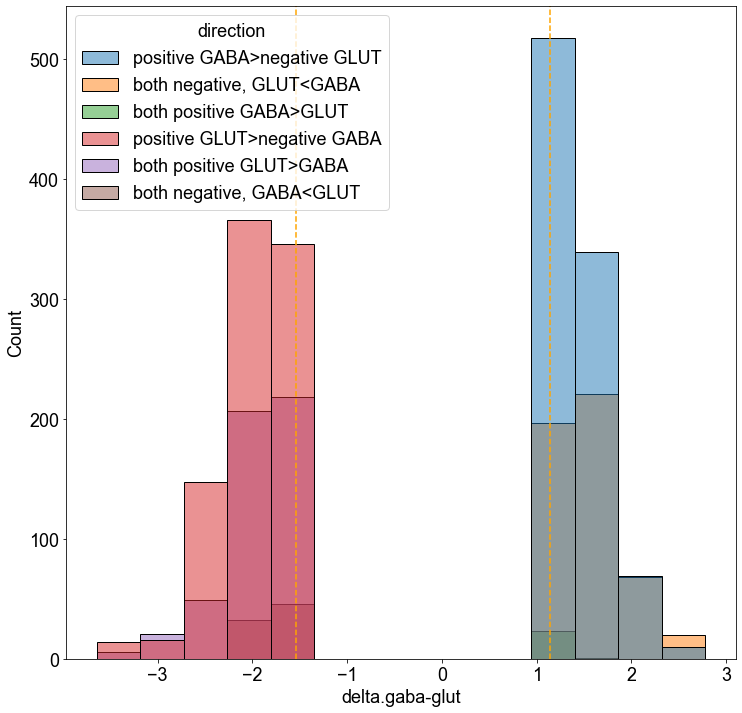

In [121]:
fig, ax=plt.subplots(figsize=(12,12))
sns.histplot(x="delta.gaba-glut", data=test, hue="direction", common_norm=False, #stat="percent"
            )
ax.axvline(np.median(bs_results975), color="orange", ls="--")
ax.axvline(np.median(bs_results025), color="orange", ls="--")
out = os.path.join(PATH, "BS_")

In [78]:
np.median(bs_results975), np.median(bs_results025)

(1.1373369503803819, -1.5434727160382518)

In [103]:
enh["bs"] = enh['delta.gaba-glut'].apply(lambda x: True if x>np.median(bs_results975) or x<np.median(bs_results025)
                                         else False)

In [115]:
cols = ["bs", 'sig',
 'direction',
 'sig_n_dif', "name"]

enh[cols].drop_duplicates().groupby(["bs", 'sig',
 'direction',
 'sig_n_dif'])["name"].count()

bs     sig    direction                    sig_n_dif  
False  False  both negative, GABA<GLUT     False.False    4868
                                           False.True      134
              both negative, GLUT<GABA     False.False    3444
                                           False.True      114
              both positive GABA>GLUT      False.False    6128
                                           False.True      783
              both positive GLUT>GABA      False.False    1573
                                           False.True     1706
              positive GABA>negative GLUT  False.False    1542
              positive GLUT>negative GABA  False.False    1059
                                           False.True      112
       True   both negative, GABA<GLUT     True.False      875
                                           True.True        39
              both negative, GLUT<GABA     True.False      435
                                           True.True        22


## That one GABA silent, glut_act

In [ ]:
val = 0
SET = gaba_sil_glut_act
already_run = []
for tile_id in SET:
    enh_id = getEnhid(tile_id, enh)
    if enh_id not in already_run:
        t = plotTile(tile_id, enh)
        already_run.append(enh_id)
        val+=1


# gaba-specific active tiles

In [ ]:
val = 0
SET = gaba_act_glut_none
already_run = []
for tile_id in SET:
    enh_id = getEnhid(tile_id, enh)
    if enh_id not in already_run:
        t = plotTile(tile_id, enh)
        already_run.append(enh_id)
        val+=1


## GABA-silent tiles

In [ ]:
val = 0
SET = gaba_sil_glut_none
already_run = []
for tile_id in SET:
    enh_id = getEnhid(tile_id, enh)
    if enh_id not in already_run:
        t = plotTile(tile_id, enh)
        already_run.append(enh_id)
        val+=1

# Glut active tiles

## glut active

In [ ]:
val = 0
SET = gaba_none_glut_act
already_run = []
for tile_id in SET:
    enh_id = getEnhid(tile_id, enh)
    if enh_id not in already_run:
        t = plotTile(tile_id, enh)
        already_run.append(enh_id)
        val+=1
    if val>5:
        break


## glut silent

In [ ]:
val = 0
SET = gaba_none_glut_sil

for enh_id in SET:
    t = plotTile(enh_id, enh)
    val+=1
    if val>5:
        break

In [ ]:
fig, ax=plt.subplots(figsize=(6,6))
sns.scatterplot(x="glut", y="gaba", data= enh, hue= "candidate")
ax.legend(bbox_to_anchor=(1,1))
out = os.path.join(PATH, "enh_maps", "summary_results.pdf")
plt.savefig(out, bbox_inches='tight')

In [ ]:
lists = [("GABA_SIL_GLUT_ACT", gaba_sil_glut_act), 
         ("GABA_SIL_GLUT_NONE", gaba_sil_glut_none),
         ("GABA_ACT_GLUT_NONE", gaba_act_glut_none),
         ("GABA_NONE_GLUT_ACT", gaba_none_glut_act), 
         ("GABA_NONE_GLUT_SIL", gaba_none_glut_sil)
        ]


outputs = {}
for name, l in lists:
    t = test.loc[test["enh.id"].isin(l)]
    t["ACT"] = name
    outputs[name]= t

In [ ]:
OUT = os.path.join(PATH, "big_effect.tsv")
pd.concat(outputs.values()).to_csv(OUT, sep='\t', index=False)